In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from datetime import datetime, timedelta
from statsmodels.distributions.empirical_distribution import ECDF

In [145]:
import seaborn as sns
sns.set()

In [149]:
from scipy.stats import gamma, expon

In [4]:
# cargar serie de datos brutos
raw = pd.read_csv('Serie_raw.csv', parse_dates=True, index_col=0)
modRaw = raw.iloc[:,0].values

# cargar series de datos observados y del modelo en el periodo observado
obs_mod = pd.read_csv('Serie_obs_mod.csv', parse_dates=True, index_col=0)
obs = obs_mod.Rain.values
modHist = obs_mod.iloc[:, 0].values

### Observación

In [141]:
class mixedCDF:
    def __init__(self, rawdata, distr):
        self.rawdata = rawdata
        self.distr = distr
        
        # serie de valores mayores de 0
        self.data = self.rawdata[rawdata > 0]
        
        # probabilidad de día seco
        self.Po = 1 - len(self.data) / len(rawdata)
        
        # ajuste de la distribución a los dias con lluvia
        self.pars = self.distr.fit(self.data)
        self.qs_ = np.linspace(0, 1 - 1e-5, 1e5)
        self.xs_ = self.distr.ppf(self.qs_, *self.pars)
        
        # ajustar la CDF empírica a los días con lluvia
        ecdf_ = ECDF(self.data)
        self.qecdf_ = ecdf_(self.data)
        
        # ajustar la CDF empírica a los días con lluvia
        ecdf = ECDF(rawdata)
        self.qecdf = ecdf(rawdata)
        
        # CDF mixta
        qs = self.Po + (1 - self.Po) * self.qs_
        self.qs = np.concatenate((np.array([0, self.Po]), qs))
        self.xs = np.concatenate((np.zeros(2), self.xs_))
        
    def plotCDF(self):
        
        fig, ax = plt.subplots(ncols=2, figsize=(10, 4.5), sharey=True)
        
        # gráfica de la CDF para los días de lluvia
        ax[0].plot(self.xs_, self.qs_, label='Gamma')
        ax[0].scatter(self.data, self.qecdf_, s=.5, c='k', label='ECDF')
        ax[0].set_title('dias con precipitación')
        ax[0].set(ylim=(0, 1.01), ylabel='CDF')
        ax[0].legend(loc=4);
        
        # gráfica de la CDF con todos los días (lluvia + secos)
        ax[1].plot(self.xs, self.qs, label='Gamma')
        ax[1].scatter(self.rawdata, self.qecdf, s=.5, c='k', label='ECDF')
        ax[1].hlines(self.Po, 0, max(np.max(self.qecdf), np.max(self.rawdata)),
                     color='grey', ls=':')
        ax[1].set_title('todos los días')
        ax[1].legend(loc=4);

<font color='indianred'> Probar función exponencial en vez de la gamma.</font>

__Observaciones__

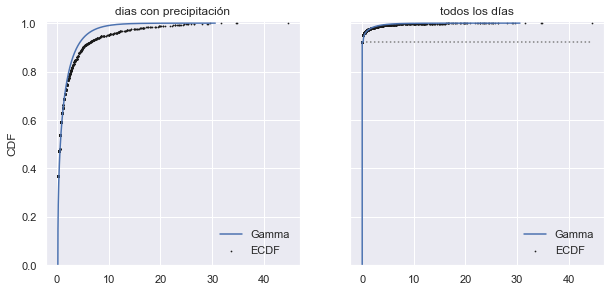

In [158]:
cdfObs = mixedCDF(obs, gamma)
cdfObs.plotCDF()

__Modelo en el perido observado__

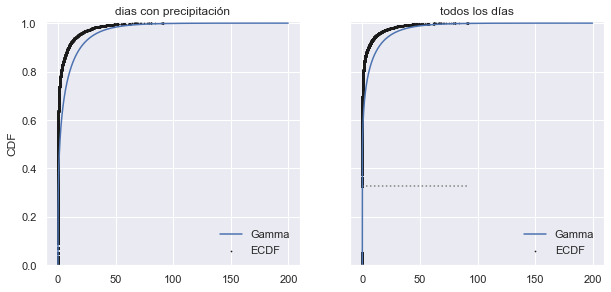

In [153]:
cdfHist = mixedCDF(modHist, gamma)
cdfHist.plotCDF()

__Modelo en el periodo no observado__

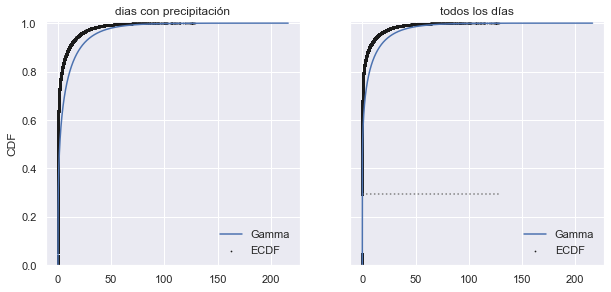

In [154]:
cdfRaw = mixedCDF(modRaw, gamma)
cdfRaw.plotCDF()

In [156]:
# cuantiles de 'modRaw' para la distribución 'cdfHist'
cdfHist.Po, cdfRaw.Po

(0.32797311559184583, 0.29454548652641943)